As the climate changes, predicting the weather becomes ever more important for businesses. You have been asked to support on a machine learning project with the aim of building a pipeline to predict the climate in London, England. Specifically, the model should predict mean temperature in degrees Celsius (°C).

We will run experiments for different regression models predicting the mean temperature, using a combination of `sklearn` and `mlflow`, and working with data stored in `london_weather.csv`, which contains the following columns:
- **date** - recorded date of measurement - (**int**)
- **cloud_cover** - cloud cover measurement in oktas - (**float**)
- **sunshine** - sunshine measurement in hours (hrs) - (**float**)
- **global_radiation** - irradiance measurement in Watt per square meter (W/m2) - (**float**)
- **max_temp** - maximum temperature recorded in degrees Celsius (°C) - (**float**)
- **mean_temp** - **target** mean temperature in degrees Celsius (°C) - (**float**)
- **min_temp** - minimum temperature recorded in degrees Celsius (°C) - (**float**)
- **precipitation** - precipitation measurement in millimeters (mm) - (**float**)
- **pressure** - pressure measurement in Pascals (Pa) - (**float**)
- **snow_depth** - snow depth measurement in centimeters (cm) - (**float**)

In [84]:
# Install mlflow
!pip install mlflow

Defaulting to user installation because normal site-packages is not writeable


In [85]:
# Import the modules
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Read in the data
weather = pd.read_csv("london_weather.csv")


# Data info and Cleaning

In [86]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB


In [87]:
print(weather.head(5))
print(weather.isna().sum())

       date  cloud_cover  sunshine  ...  precipitation  pressure  snow_depth
0  19790101          2.0       7.0  ...            0.4  101900.0         9.0
1  19790102          6.0       1.7  ...            0.0  102530.0         8.0
2  19790103          5.0       0.0  ...            0.0  102050.0         4.0
3  19790104          8.0       0.0  ...            0.0  100840.0         2.0
4  19790105          6.0       2.0  ...            0.0  102250.0         1.0

[5 rows x 10 columns]
date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64


In [88]:
metrics = list(weather) 
metrics.remove('date')  
# OR list(weather.columns)

print(metrics)

['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth']


In [89]:
# Convert to standard date
weather['date'] = pd.to_datetime(weather['date'], format = '%Y%m%d')
weather['year'] = weather['date'].dt.year
weather['month'] = weather['date'].dt.month

# Monthly average
weather_month = weather.groupby(['year', 'month'])[metrics].mean()
print(weather_month.head(5))

            cloud_cover  sunshine  ...       pressure  snow_depth
year month                         ...                           
1979 1         5.724138  1.887097  ...  101214.838710    1.354839
     2         6.360000  1.889286  ...  101163.928571    0.107143
     3         5.967742  3.212903  ...  100459.032258    0.032258
     4         6.133333  3.543333  ...  101165.333333    0.000000
     5         5.290323  6.470968  ...  101362.580645    0.000000

[5 rows x 9 columns]


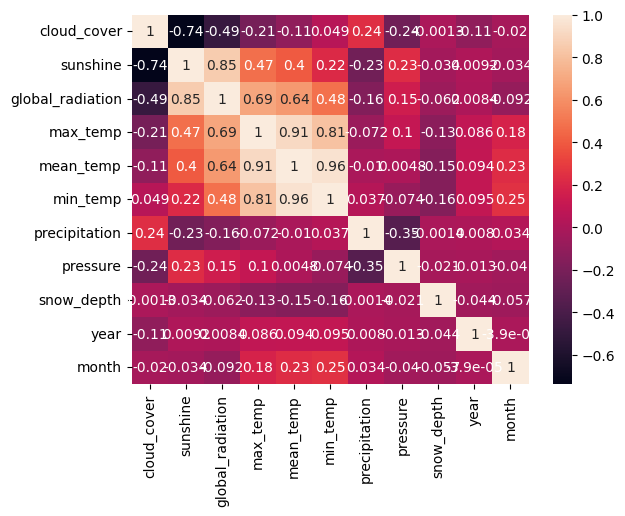

In [90]:
# Correlations
sns.heatmap(weather.corr(), annot = True)
plt.show()

In [91]:
# remove param if corr > 0.85, as well as snow_depth
features = ['month', 'cloud_cover', 'sunshine', 'precipitation', 'pressure']
target = 'mean_temp'

weather_lite = weather[features + [target]]
weather_lite.isna().sum()
weather_lite.dropna(inplace = True)



# Training and Evaluating with MlFlow

In [92]:
X = weather_lite[features]
y = weather_lite[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)


#   If we kept lines with missing data :

# imputer = SimpleImputer(strategy="mean")
# X_train = imputer.fit_transform(X_train)
# X_test  = imputer.transform(X_test)


# Scale data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  

In [93]:
# Linear regression
with mlflow.start_run(run_name = 'Linear'):
    #Model and log
    lin_reg = LinearRegression().fit(X_train, y_train)
    mlflow.sklearn.log_model(lin_reg, "linear")
    
    #Evaluation
    y_pred_lin_reg = lin_reg.predict(X_test)
    lin_reg_rmse = mean_squared_error(y_test, y_pred_lin_reg, squared=False)
    mlflow.log_metric("rmse_linaer", lin_reg_rmse)

        


In [94]:
# MLFlow loop for trees

for i, depth in enumerate([1,3,9,15]):
    run_str = f'run_{i}'
    with mlflow.start_run(run_name = run_str):

        # Models
        tree_reg = DecisionTreeRegressor(random_state=42, max_depth=depth).fit(X_train, y_train)
        #forest_reg = RandomForestRegressor(random_state=42, max_depth=depth).fit(X_train, y_train)
        
        # Logs
        mlflow.sklearn.log_model(tree_reg, "tree")
        #mlflow.sklearn.log_model(forest_reg, "forest")
        
        # Evaluation
        y_pred_tree_reg = tree_reg.predict(X_test)
        tree_reg_rmse = mean_squared_error(y_test, y_pred_tree_reg, squared=False)
        #y_pred_forest_reg = forest_reg.predict(X_test)
        #forest_reg_rmse = mean_squared_error(y_test, y_pred_forest_reg, squared=False)
        
        # Logs performances
        mlflow.log_param("max_depth", depth)
        mlflow.log_metric("rmse_tree", tree_reg_rmse)
        #mlflow.log_metric("rmse_forest", forest_reg_rmse)
        
        
        

In [95]:
experiment_results = mlflow.search_runs()
experiment_results

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.rmse_tree,metrics.rmse_linaer,params.max_depth,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.log-model.history,tags.mlflow.user
0,7f010db323c64e8c9c4edd73e6381310,0,FINISHED,file:///work/files/workspace/mlruns/0/7f010db3...,2024-02-21 13:45:04.725000+00:00,2024-02-21 13:45:07.396000+00:00,3.507137,NaN,15,LOCAL,run_3,/usr/lib/python3/dist-packages/python_kernel/k...,"[{""run_id"": ""7f010db323c64e8c9c4edd73e6381310""...",repl
1,7ff34e45c8824e31aee20fc05b582f2f,0,FINISHED,file:///work/files/workspace/mlruns/0/7ff34e45...,2024-02-21 13:45:02.131000+00:00,2024-02-21 13:45:04.701000+00:00,2.964789,NaN,9,LOCAL,run_2,/usr/lib/python3/dist-packages/python_kernel/k...,"[{""run_id"": ""7ff34e45c8824e31aee20fc05b582f2f""...",repl
2,a3ec47df55ad4789981289315202488f,0,FINISHED,file:///work/files/workspace/mlruns/0/a3ec47df...,2024-02-21 13:44:59.663000+00:00,2024-02-21 13:45:02.106000+00:00,3.398749,NaN,3,LOCAL,run_1,/usr/lib/python3/dist-packages/python_kernel/k...,"[{""run_id"": ""a3ec47df55ad4789981289315202488f""...",repl
3,8da30cb835624a7a95c581e01fa09710,0,FINISHED,file:///work/files/workspace/mlruns/0/8da30cb8...,2024-02-21 13:44:57.138000+00:00,2024-02-21 13:44:59.642000+00:00,4.721861,NaN,1,LOCAL,run_0,/usr/lib/python3/dist-packages/python_kernel/k...,"[{""run_id"": ""8da30cb835624a7a95c581e01fa09710""...",repl
4,3092472b8dc44e05b04a953625c8bf94,0,FINISHED,file:///work/files/workspace/mlruns/0/3092472b...,2024-02-21 13:44:54.585000+00:00,2024-02-21 13:44:57.104000+00:00,NaN,4.839023,None,LOCAL,Linear,/usr/lib/python3/dist-packages/python_kernel/k...,"[{""run_id"": ""3092472b8dc44e05b04a953625c8bf94""...",repl
5,252d7dcece0c4b5a9d67812de1cc2d0d,0,FINISHED,file:///work/files/workspace/mlruns/0/252d7dce...,2024-02-21 13:42:24.297000+00:00,2024-02-21 13:42:27.012000+00:00,3.507137,NaN,15,LOCAL,run_3,/usr/lib/python3/dist-packages/python_kernel/k...,"[{""run_id"": ""252d7dcece0c4b5a9d67812de1cc2d0d""...",repl
6,40e35ec0151846f79f1e720db9496908,0,FINISHED,file:///work/files/workspace/mlruns/0/40e35ec0...,2024-02-21 13:42:21.850000+00:00,2024-02-21 13:42:24.276000+00:00,2.964789,NaN,9,LOCAL,run_2,/usr/lib/python3/dist-packages/python_kernel/k...,"[{""run_id"": ""40e35ec0151846f79f1e720db9496908""...",repl
7,1c72735f57344978b3fb642988c57e64,0,FINISHED,file:///work/files/workspace/mlruns/0/1c72735f...,2024-02-21 13:42:19.331000+00:00,2024-02-21 13:42:21.829000+00:00,3.398749,NaN,3,LOCAL,run_1,/usr/lib/python3/dist-packages/python_kernel/k...,"[{""run_id"": ""1c72735f57344978b3fb642988c57e64""...",repl
8,415388aa7946426e99500d05da727e36,0,FINISHED,file:///work/files/workspace/mlruns/0/415388aa...,2024-02-21 13:42:16.830000+00:00,2024-02-21 13:42:19.310000+00:00,4.721861,NaN,1,LOCAL,run_0,/usr/lib/python3/dist-packages/python_kernel/k...,"[{""run_id"": ""415388aa7946426e99500d05da727e36""...",repl
9,d10adc9d0cd44e3f86ab0affce15c905,0,FINISHED,file:///work/files/workspace/mlruns/0/d10adc9d...,2024-02-21 13:42:14.278000+00:00,2024-02-21 13:42:16.711000+00:00,NaN,4.839023,None,LOCAL,Linear,/usr/lib/python3/dist-packages/python_kernel/k...,"[{""run_id"": ""d10adc9d0cd44e3f86ab0affce15c905""...",repl
